# Installing and importing packages


In [1]:
!pip install -qU svgwrite ndjson torch

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\convert-caffe2-to-onnx.exe' -> 'C:\\Python312\\Scripts\\convert-caffe2-to-onnx.exe.deleteme'



In [244]:
import requests
import ndjson
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time
import svgwrite
from IPython.display import SVG, display, clear_output
from tqdm import trange
import matplotlib.pyplot as plt

# Setting pre-train parameters and user-controlled knobs

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/triangle.ndjson'
max_doodle_len = 5
max_stroke_len = 1
max_gen_len = 1

batch_size = 50
lr = 0.001
num_epochs = 5
hidden_size = 512
latent_size = 128
num_layers = 6
num_heads = 8
ff_dim = 2048
dropout = 0

# Util functions for data pre-processing

In [4]:
def load_data():
    response = requests.get(dataset_url)
    data = ndjson.loads(response.text)
    return data

In [5]:
def extract_useful_doodles(data):
    useful_doodles = []
    for doodle in data:
        if doodle['recognized']:
            useful_doodles.append(doodle['drawing'])
    return useful_doodles

In [6]:
def zip_strokes(data):
    new_data = []
    for doodle in data:
        new_data.append([[list(x) for x in zip(stroke[0], stroke[1])] for stroke in doodle])
    return new_data

In [7]:
def pad_all_doodles(data):
    global max_stroke_len
    for doodle in data:
        max_stroke_len = max(
            max_stroke_len,
            max([len(stroke) for stroke in doodle])
        )

    new_data = []
    for doodle in data:
        new_doodle = []
        for stroke in doodle:
            new_stroke = np.pad(
                stroke,
                ((max_stroke_len - len(stroke), 0), (0, 0)),
                mode='constant',
                constant_values=0
            )
            new_doodle.append(new_stroke)
        new_data.append(np.array(new_doodle))

    for index, doodle in enumerate(new_data):
        if max_doodle_len <= doodle.shape[0]:
            new_data[index] = doodle[doodle.shape[0] - max_doodle_len:]
        else:
            new_data[index] = np.pad(
                doodle,
                ((max_doodle_len - doodle.shape[0], 0), (max_stroke_len - doodle.shape[1], 0), (2 - doodle.shape[2], 0))
            )

    new_data = np.array(new_data)
    new_data = new_data.reshape(new_data.shape[0], new_data.shape[1], -1)

    return new_data

# Util functions for visualizations

In [8]:
def draw_strokes_real_time(strokes):
    strokes = np.flip(strokes, axis=1)

    dwg = svgwrite.Drawing(size=(255, 255))
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), fill='white'))
    display(SVG(dwg.tostring()))

    idx = 2
    for stroke in strokes:
        polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="black", fill="none", stroke_width=2)

        dwg.add(polyline)

        points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
        for point in points:
            if point == (0, 0): continue
            #print(point)
            polyline.points.append(point)
            display(SVG(dwg.tostring()))
            time.sleep(0.03)
            clear_output(wait=True)

In [9]:
def draw_strokes_real_time_for_viz(strokes):
    strokes = np.flip(strokes, axis=1)

    dwg = svgwrite.Drawing(size=(255, 255))
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), fill='white'))
    display(SVG(dwg.tostring()))

    idx = 2
    for stroke in strokes[:-1]:
        polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="black", fill="none", stroke_width=2)

        dwg.add(polyline)

        points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
        for point in points:
            if point == (0, 0): continue
            #print(point)
            polyline.points.append(point)
            display(SVG(dwg.tostring()))
            time.sleep(0.03)
            clear_output(wait=True)

    stroke = strokes[-1]
    polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="red", fill="none", stroke_width=2)

    dwg.add(polyline)

    points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
    for point in points:
        if point == (0, 0): continue
        #print(point)
        polyline.points.append(point)
        display(SVG(dwg.tostring()))
        time.sleep(0.03)
        clear_output(wait=True)

# Import, process and test our dataset

In [10]:
dataset = load_data()

In [11]:
doodles = extract_useful_doodles(dataset)

In [12]:
doodles = zip_strokes(doodles)

# Sanity check
assert np.allclose(
    np.array([list(x) for x in zip(dataset[0]['drawing'][0][0], dataset[0]['drawing'][0][1])]),
    doodles[0][0]
)

In [13]:
doodles = pad_all_doodles(doodles)

# Sanity check
assert type(doodles[0]) == type(np.array([[]]))

In [14]:
display(doodles.shape)

(120500, 5, 212)

In [289]:
for i in np.random.randint(0, len(doodles), size=10):
    draw_strokes_real_time(doodles[i])
    time.sleep(0.5)

ValueError: step must be greater than zero

# Train test val split

In [16]:
class DoodleDataset(Dataset):
    def __init__(self, doodles):
        self.doodles = doodles

    def __len__(self):
        return len(self.doodles)

    def __getitem__(self, idx):
        # Get a single doodle from the array
        doodle = self.doodles[idx]
        return doodle

In [17]:
doodles = torch.tensor(doodles)
train_data, test_data = train_test_split(doodles, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("train data:", len(train_data))
print("test data:", len(test_data))
print("val data:", len(val_data))

train data: 86760
test data: 12050
val data: 21690


In [18]:
print(train_data)

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ..., 126,   0, 134]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ..., 195,   5, 136]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,  10,  51,   0]],

        ...,

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ..., 161,   0, 227],
         [  0,   0,   0,  ..., 130, 208, 255],
         [  0,   0,   0,  ..., 228, 205, 237]],

        [[  0,   0,   0,  ...,   0,   

In [40]:
print(test_data[104][4])

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [19]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [51]:
test_data_first_batch = test_data[:50]
print(test_data_first_batch.shape)

torch.Size([50, 5, 212])


# Define the transformer-based encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # print("Encoder input shape", x.shape)
        _, (h, _) = self.rnn(x)
        latent_representation = self.fc(h.squeeze(0))
        # print("Encoder latent state shape", latent_representation.shape)
        return latent_representation

# Define the transformer-based decoder

In [21]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # print("Decoder input shape", x.shape)
        output, _ = self.rnn(x, hidden)
        output = self.fc(output)
        # print("Decoder output shape", output.shape)
        return output

# Use the encoder and decoder in a model

In [22]:
class SketchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(SketchRNN, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)

    def forward(self, x):
        latent_representation = self.encoder(x)
        # Replicate latent representation to match batch size of input data
        latent_representation = latent_representation.unsqueeze(1).repeat(1, x.size(1), 1)
        output = self.decoder(latent_representation, None)
        return output

# Define the training function

In [ ]:
def train_model(model, train_loader, criterion, optimizer, val_loader):
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Inside the training loop
        data_loader_iter = iter(train_loader)
        total_batches = len(train_loader)

        for _ in trange(total_batches):
            strokes = next(data_loader_iter)  # Extract strokes
            optimizer.zero_grad()

            strokes = strokes.float()  # Convert to float
            # print("Input data shape", strokes.shape)

            # Obtain output from the model using input data (strokes)
            output = model(strokes)

            # Reshape output tensor to match the shape of strokes tensor
            output = output.view(strokes.shape[0], -1, output.size(2))
            # print("Output shape", output.shape)

            # Flatten the strokes tensor for the loss calculation
            strokes_flat = strokes.view(-1, strokes.size(-1))  # This flattens while preserving the batch size

            # Ensure strokes_flat has the same batch size as the output tensor
            strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
            strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
            # print("Target shape", strokes_flat.shape)

            # Calculate loss and update model parameters
            loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0
        data_loader_iter = iter(train_loader)
        total_batches = len(train_loader)
        with torch.no_grad():  # Disable gradient tracking for validation
            for _ in trange(total_batches):
                strokes = next(data_loader_iter)  # Extract strokes
                strokes = strokes.float()
                output = model(strokes)
                output = output.view(strokes.shape[0], -1, output.size(2))
                strokes_flat = strokes.view(-1, strokes.size(-1))
                strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
                strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
                loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
                total_val_loss += loss.item()

        loss = total_loss / len(train_loader)
        losses.append(loss)
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss}, Validation Loss: {val_loss}\n")

    torch.save(model.state_dict(), 'model.pth')
    return losses, val_losses

# Train the model

In [ ]:
num_epochs = 100
input_size  = doodles.shape[-1]
output_size = doodles.shape[-1]

model = SketchRNN(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_losses = train_model(model, train_loader, criterion, optimizer, val_loader)

  0%|          | 0/1735 [00:00<?, ?it/s]

100%|██████████| 1735/1735 [00:33<00:00, 51.93it/s]


Epoch 1/100, Train Loss: 246.60153632699928, Validation Loss: 644.9937352098989



100%|██████████| 1735/1735 [00:33<00:00, 51.94it/s]


Epoch 2/100, Train Loss: 117.94262410364509, Validation Loss: 356.11172012258623



100%|██████████| 1735/1735 [00:33<00:00, 51.82it/s]


Epoch 3/100, Train Loss: 69.54851389288558, Validation Loss: 217.70592135810412



100%|██████████| 1735/1735 [00:33<00:00, 51.37it/s]


Epoch 4/100, Train Loss: 47.996702119458995, Validation Loss: 167.45996769030705



100%|██████████| 1735/1735 [00:33<00:00, 51.72it/s]


Epoch 5/100, Train Loss: 38.15364308865682, Validation Loss: 137.37951804198514



100%|██████████| 1735/1735 [00:33<00:00, 51.47it/s]


Epoch 6/100, Train Loss: 32.30491153925915, Validation Loss: 117.53505050227493



100%|██████████| 1735/1735 [00:33<00:00, 51.43it/s]


Epoch 7/100, Train Loss: 28.421066775583053, Validation Loss: 107.14538455945515



100%|██████████| 1735/1735 [00:33<00:00, 51.56it/s]


Epoch 8/100, Train Loss: 25.577674781073753, Validation Loss: 95.63525966133311



100%|██████████| 1735/1735 [00:33<00:00, 51.85it/s]


Epoch 9/100, Train Loss: 23.39139425569034, Validation Loss: 88.82759594641988



100%|██████████| 1735/1735 [00:33<00:00, 51.84it/s]


Epoch 10/100, Train Loss: 21.439331595011335, Validation Loss: 82.98543069103849



100%|██████████| 1735/1735 [00:33<00:00, 51.96it/s]


Epoch 11/100, Train Loss: 20.07750389582829, Validation Loss: 77.66710636632271



100%|██████████| 1735/1735 [00:33<00:00, 52.22it/s]


Epoch 12/100, Train Loss: 18.992499962732495, Validation Loss: 72.19584680209259



100%|██████████| 1735/1735 [00:33<00:00, 51.97it/s]


Epoch 13/100, Train Loss: 17.960452963639405, Validation Loss: 69.98729139993152



100%|██████████| 1735/1735 [00:33<00:00, 52.36it/s]


Epoch 14/100, Train Loss: 16.980875703443367, Validation Loss: 64.84457523332732



100%|██████████| 1735/1735 [00:33<00:00, 51.82it/s]


Epoch 15/100, Train Loss: 16.193869469832276, Validation Loss: 61.70665876639632



100%|██████████| 1735/1735 [00:33<00:00, 51.66it/s]


Epoch 16/100, Train Loss: 15.525277277646904, Validation Loss: 59.719677751113856



100%|██████████| 1735/1735 [00:33<00:00, 51.61it/s]


Epoch 17/100, Train Loss: 14.841848891200524, Validation Loss: 57.43594909540225



100%|██████████| 1735/1735 [00:33<00:00, 51.78it/s]


Epoch 18/100, Train Loss: 14.200191178995182, Validation Loss: 55.06533182906224



100%|██████████| 1735/1735 [00:33<00:00, 51.63it/s]


Epoch 19/100, Train Loss: 13.644884007808454, Validation Loss: 52.53249191301799



100%|██████████| 1735/1735 [00:33<00:00, 51.33it/s]


Epoch 20/100, Train Loss: 13.35453820077418, Validation Loss: 51.059387048452614



100%|██████████| 1735/1735 [00:33<00:00, 51.91it/s]


Epoch 21/100, Train Loss: 12.903424281414372, Validation Loss: 49.303438020358186



100%|██████████| 1735/1735 [00:33<00:00, 51.71it/s]


Epoch 22/100, Train Loss: 12.40099076317779, Validation Loss: 47.27610444802335



100%|██████████| 1735/1735 [00:34<00:00, 50.97it/s]


Epoch 23/100, Train Loss: 12.057920398217457, Validation Loss: 47.7529631564028



100%|██████████| 1735/1735 [00:34<00:00, 50.25it/s]


Epoch 24/100, Train Loss: 11.756757474838828, Validation Loss: 45.040942556588256



100%|██████████| 1735/1735 [00:33<00:00, 51.27it/s]


Epoch 25/100, Train Loss: 11.479324198731085, Validation Loss: 44.56146556290413



100%|██████████| 1735/1735 [00:33<00:00, 51.81it/s]


Epoch 26/100, Train Loss: 11.161217096697014, Validation Loss: 43.6017734051852



100%|██████████| 1735/1735 [00:33<00:00, 52.13it/s]


Epoch 27/100, Train Loss: 10.92275036968484, Validation Loss: 41.64139081369096



100%|██████████| 1735/1735 [00:33<00:00, 52.48it/s]


Epoch 28/100, Train Loss: 10.727612142535383, Validation Loss: 41.6639863503172



100%|██████████| 1735/1735 [00:33<00:00, 51.67it/s]


Epoch 29/100, Train Loss: 10.385221988941819, Validation Loss: 39.83653585024298



100%|██████████| 1735/1735 [00:33<00:00, 51.35it/s]


Epoch 30/100, Train Loss: 10.239291448895457, Validation Loss: 39.15341289489429



100%|██████████| 1735/1735 [00:33<00:00, 51.97it/s]


Epoch 31/100, Train Loss: 9.988205245729826, Validation Loss: 39.128157125609576



100%|██████████| 1735/1735 [00:33<00:00, 51.28it/s]


Epoch 32/100, Train Loss: 9.854729740901364, Validation Loss: 39.60467625214927



100%|██████████| 1735/1735 [00:33<00:00, 51.96it/s]


Epoch 33/100, Train Loss: 9.621763567690891, Validation Loss: 36.90942127875313



100%|██████████| 1735/1735 [00:36<00:00, 47.49it/s]


Epoch 34/100, Train Loss: 9.537765933594718, Validation Loss: 37.40938140833901



100%|██████████| 1735/1735 [00:36<00:00, 47.93it/s]


Epoch 35/100, Train Loss: 9.347152614318672, Validation Loss: 36.76313750903546



100%|██████████| 1735/1735 [00:33<00:00, 51.44it/s]


Epoch 36/100, Train Loss: 9.177422511405835, Validation Loss: 35.411582503528024



100%|██████████| 1735/1735 [00:33<00:00, 51.37it/s]


Epoch 37/100, Train Loss: 9.11383314476233, Validation Loss: 35.15911988022696



100%|██████████| 1735/1735 [00:33<00:00, 51.38it/s]


Epoch 38/100, Train Loss: 8.986091528296127, Validation Loss: 35.37713810147645



100%|██████████| 1735/1735 [00:33<00:00, 51.59it/s]


Epoch 39/100, Train Loss: 8.90602430101774, Validation Loss: 34.48021241313591



100%|██████████| 1735/1735 [00:33<00:00, 51.16it/s]


Epoch 40/100, Train Loss: 8.756398340604491, Validation Loss: 33.98356583046858



100%|██████████| 1735/1735 [00:33<00:00, 51.63it/s]


Epoch 41/100, Train Loss: 8.645440366563605, Validation Loss: 33.67971911771743



100%|██████████| 1735/1735 [00:33<00:00, 51.57it/s]


Epoch 42/100, Train Loss: 8.4731510335499, Validation Loss: 32.95041372374079



100%|██████████| 1735/1735 [00:34<00:00, 50.79it/s]


Epoch 43/100, Train Loss: 8.480393482834874, Validation Loss: 32.59176386696637



100%|██████████| 1735/1735 [00:33<00:00, 51.87it/s]


Epoch 44/100, Train Loss: 8.27971302260583, Validation Loss: 32.97263562431512



100%|██████████| 1735/1735 [00:33<00:00, 51.98it/s]


Epoch 45/100, Train Loss: 8.201329026235971, Validation Loss: 31.498159602387673



100%|██████████| 1735/1735 [00:33<00:00, 51.38it/s]


Epoch 46/100, Train Loss: 8.094248636586522, Validation Loss: 31.459920491687697



100%|██████████| 1735/1735 [00:34<00:00, 50.87it/s]


Epoch 47/100, Train Loss: 7.980510240741697, Validation Loss: 32.27507982022768



100%|██████████| 1735/1735 [00:33<00:00, 51.64it/s]


Epoch 48/100, Train Loss: 7.989380658531739, Validation Loss: 30.44842737376277



100%|██████████| 1735/1735 [00:33<00:00, 51.25it/s]


Epoch 49/100, Train Loss: 7.7759086405509485, Validation Loss: 30.52041074695543



100%|██████████| 1735/1735 [00:33<00:00, 51.66it/s]


Epoch 50/100, Train Loss: 7.819551309865902, Validation Loss: 30.485487260664307



100%|██████████| 1735/1735 [00:33<00:00, 51.67it/s]


Epoch 51/100, Train Loss: 7.643152661831991, Validation Loss: 30.227851891352454



100%|██████████| 1735/1735 [00:33<00:00, 51.54it/s]


Epoch 52/100, Train Loss: 7.626945253064378, Validation Loss: 29.543563757427293



100%|██████████| 1735/1735 [00:33<00:00, 52.10it/s]


Epoch 53/100, Train Loss: 7.517245302007933, Validation Loss: 29.48872386886121



100%|██████████| 1735/1735 [00:33<00:00, 51.82it/s]


Epoch 54/100, Train Loss: 7.4563346756981845, Validation Loss: 28.59754809441247



100%|██████████| 1735/1735 [00:34<00:00, 50.91it/s]


Epoch 55/100, Train Loss: 7.419795580075179, Validation Loss: 28.68227181643867



100%|██████████| 1735/1735 [00:33<00:00, 51.39it/s]


Epoch 56/100, Train Loss: 7.251346011945081, Validation Loss: 29.16457326142397



100%|██████████| 1735/1735 [00:34<00:00, 50.85it/s]


Epoch 57/100, Train Loss: 7.244005838251251, Validation Loss: 27.776730160790283



100%|██████████| 1735/1735 [00:34<00:00, 51.00it/s]


Epoch 58/100, Train Loss: 7.169253913263766, Validation Loss: 28.039124167818947



100%|██████████| 1735/1735 [00:33<00:00, 51.34it/s]


Epoch 59/100, Train Loss: 7.0677407873466995, Validation Loss: 29.059899643442098



100%|██████████| 1735/1735 [00:33<00:00, 51.91it/s]


Epoch 60/100, Train Loss: 7.062015039158142, Validation Loss: 27.211298700292996



100%|██████████| 1735/1735 [00:33<00:00, 51.43it/s]


Epoch 61/100, Train Loss: 6.985444316809047, Validation Loss: 27.891385917575477



100%|██████████| 1735/1735 [00:33<00:00, 51.22it/s]


Epoch 62/100, Train Loss: 7.020208842335242, Validation Loss: 26.716487315730742



100%|██████████| 1735/1735 [00:34<00:00, 50.20it/s]


Epoch 63/100, Train Loss: 6.904481191525198, Validation Loss: 27.416018475010542



100%|██████████| 1735/1735 [00:34<00:00, 50.76it/s]


Epoch 64/100, Train Loss: 6.886485381085179, Validation Loss: 26.973265911635295



100%|██████████| 1735/1735 [00:33<00:00, 51.56it/s]


Epoch 65/100, Train Loss: 6.762119191661692, Validation Loss: 26.024505307437643



100%|██████████| 1735/1735 [00:34<00:00, 50.54it/s]


Epoch 66/100, Train Loss: 6.702438451508624, Validation Loss: 26.61672760157332



100%|██████████| 1735/1735 [00:33<00:00, 52.14it/s]


Epoch 67/100, Train Loss: 6.753422263857267, Validation Loss: 26.702731530055164



100%|██████████| 1735/1735 [00:49<00:00, 35.01it/s]


Epoch 68/100, Train Loss: 6.756914817634165, Validation Loss: 26.02202940372617



100%|██████████| 1735/1735 [00:34<00:00, 51.03it/s]


Epoch 69/100, Train Loss: 6.620447150980705, Validation Loss: 25.92178914618547



100%|██████████| 1735/1735 [00:33<00:00, 51.43it/s]


Epoch 70/100, Train Loss: 6.589169217942428, Validation Loss: 26.032184338734826



100%|██████████| 1735/1735 [00:33<00:00, 51.11it/s]


Epoch 71/100, Train Loss: 6.547123356580047, Validation Loss: 25.67859176840573



100%|██████████| 1735/1735 [00:33<00:00, 51.51it/s]


Epoch 72/100, Train Loss: 6.568694328505986, Validation Loss: 26.11252954650421



100%|██████████| 1735/1735 [00:33<00:00, 51.83it/s]


Epoch 73/100, Train Loss: 6.476864065148301, Validation Loss: 24.412527059022054



100%|██████████| 1735/1735 [00:33<00:00, 51.31it/s]


Epoch 74/100, Train Loss: 6.3542654874345414, Validation Loss: 25.240363764707816



100%|██████████| 1735/1735 [00:33<00:00, 51.14it/s]


Epoch 75/100, Train Loss: 6.419959679804205, Validation Loss: 24.65500305211021



100%|██████████| 1735/1735 [00:33<00:00, 51.60it/s]


Epoch 76/100, Train Loss: 6.396840206965246, Validation Loss: 25.208735953302362



100%|██████████| 1735/1735 [00:33<00:00, 51.56it/s]


Epoch 77/100, Train Loss: 6.452166465792257, Validation Loss: 24.433502980798277



100%|██████████| 1735/1735 [00:33<00:00, 51.82it/s]


Epoch 78/100, Train Loss: 6.284079778984576, Validation Loss: 24.04076291727414



100%|██████████| 1735/1735 [00:34<00:00, 50.95it/s]


Epoch 79/100, Train Loss: 6.20923554821729, Validation Loss: 23.943953401221965



100%|██████████| 1735/1735 [00:34<00:00, 49.71it/s]


Epoch 80/100, Train Loss: 6.205002106575869, Validation Loss: 24.201392803126065



100%|██████████| 1735/1735 [00:34<00:00, 50.44it/s]


Epoch 81/100, Train Loss: 6.236710691452027, Validation Loss: 23.75942882214077



100%|██████████| 1735/1735 [00:33<00:00, 51.24it/s]


Epoch 82/100, Train Loss: 6.13503762404582, Validation Loss: 23.7634297766256



100%|██████████| 1735/1735 [00:33<00:00, 51.30it/s]


Epoch 83/100, Train Loss: 6.1317028953980985, Validation Loss: 23.675956684227078



100%|██████████| 1735/1735 [00:34<00:00, 50.02it/s]


Epoch 84/100, Train Loss: 6.042319578258724, Validation Loss: 23.70679433846859



100%|██████████| 1735/1735 [00:33<00:00, 51.70it/s]


Epoch 85/100, Train Loss: 6.11399193675786, Validation Loss: 23.735904118755947



100%|██████████| 1735/1735 [00:34<00:00, 50.10it/s]


Epoch 86/100, Train Loss: 6.042913436065146, Validation Loss: 23.179456700353644



100%|██████████| 1735/1735 [00:34<00:00, 50.63it/s]


Epoch 87/100, Train Loss: 6.043020206500886, Validation Loss: 23.317176651459093



100%|██████████| 1735/1735 [00:34<00:00, 50.34it/s]


Epoch 88/100, Train Loss: 6.042063762818702, Validation Loss: 23.290406201232663



100%|██████████| 1735/1735 [00:33<00:00, 51.26it/s]


Epoch 89/100, Train Loss: 5.970884582151253, Validation Loss: 23.28769098143104



100%|██████████| 1735/1735 [00:34<00:00, 50.53it/s]


Epoch 90/100, Train Loss: 6.048443544014043, Validation Loss: 23.01853786770246



100%|██████████| 1735/1735 [00:35<00:00, 49.50it/s]


Epoch 91/100, Train Loss: 5.91290774015597, Validation Loss: 22.709825167204436



100%|██████████| 1735/1735 [00:34<00:00, 50.85it/s]


Epoch 92/100, Train Loss: 5.881147717055395, Validation Loss: 22.818592998777746



100%|██████████| 1735/1735 [00:35<00:00, 49.48it/s]


Epoch 93/100, Train Loss: 5.8808032170496345, Validation Loss: 23.392148191328687



100%|██████████| 1735/1735 [00:36<00:00, 47.93it/s]


Epoch 94/100, Train Loss: 5.913856241682421, Validation Loss: 23.13556186541674



100%|██████████| 1735/1735 [00:34<00:00, 49.86it/s]


Epoch 95/100, Train Loss: 5.817894090767896, Validation Loss: 23.456096741674127



100%|██████████| 1735/1735 [00:34<00:00, 50.04it/s]


Epoch 96/100, Train Loss: 5.779908377567698, Validation Loss: 22.82883890561639



100%|██████████| 1735/1735 [00:35<00:00, 49.48it/s]


Epoch 97/100, Train Loss: 5.716994540629538, Validation Loss: 22.500582557352256



100%|██████████| 1735/1735 [00:35<00:00, 49.14it/s]


Epoch 98/100, Train Loss: 5.666507089515928, Validation Loss: 22.112648400643682



100%|██████████| 1735/1735 [00:36<00:00, 47.88it/s]


Epoch 99/100, Train Loss: 5.71665120537068, Validation Loss: 22.248297904985883



100%|██████████| 1735/1735 [00:34<00:00, 50.84it/s]

Epoch 100/100, Train Loss: 5.714131714218975, Validation Loss: 22.19399807029178



# Set the models to eval, and run tests

In [29]:
def test_model(model, test_loader, criterion):
    # Test
    model.eval()  # Set model to evaluation mode

    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in test_loader:
            strokes = batch.float()
            output = model(strokes)
            output = output.view(strokes.shape[0], -1, output.size(2))
            strokes_flat = strokes.view(-1, strokes.size(-1))
            strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
            strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
            loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
            total_test_loss += loss.item()

    test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {test_loss}\n")
    return test_loss

In [ ]:
test_loss = test_model(model, test_loader, criterion)

NameError: name 'model' is not defined

# Plots to visualize the training process

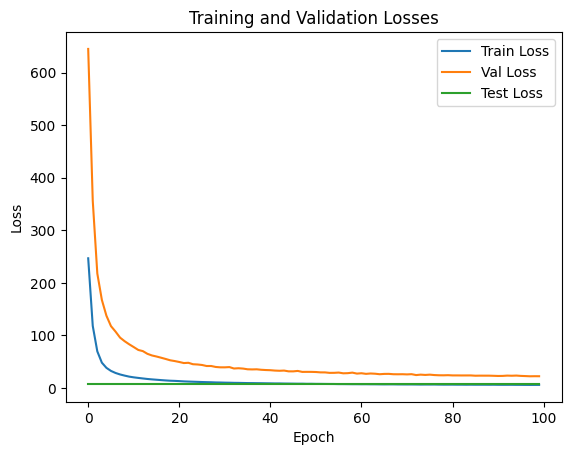

In [ ]:
# Plot the losses
import matplotlib.pyplot as plt

plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot([test_loss]*num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# User Input

In [108]:
from IPython.display import display, HTML, Javascript, JSON

In [398]:
save_strokes = []

def display_canvas(width=255, height=255, line_width=2):
    global save_strokes
    """Renders an HTML canvas in the Jupyter notebook with drawing and save functionality."""
    html_template = f"""
    <canvas id="canvas" width="{width}" height="{height}" style="border:1px solid #000000; background-color: white;"></canvas>
    <button id="saveBtn">Save Drawing</button>
    <div id="strokesDisplay"></div>
    <script>
    (function() {{
        const canvas = document.getElementById('canvas');
        const ctx = canvas.getContext('2d');
        ctx.lineWidth = {line_width};
        ctx.strokeStyle = "black";
        ctx.lineCap = 'round';

        let isDrawing = false;
        let strokes = [];

        canvas.addEventListener('mousedown', function(e) {{
            isDrawing = true;
            const pos = getMousePos(e);
            strokes.push([pos.x, pos.y]);
            ctx.beginPath();
            ctx.moveTo(pos.x, pos.y);
        }});

        canvas.addEventListener('mousemove', function(e) {{
            if (isDrawing) {{
                const pos = getMousePos(e);
                strokes.push([pos.x, pos.y]);
                ctx.lineTo(pos.x, pos.y);
                ctx.stroke();
            }}
        }});

        canvas.addEventListener('mouseup', function(e) {{
            isDrawing = false;
            const strokesDisplay = document.getElementById('strokesDisplay');
            strokesDisplay.innerHTML = "<b>Strokes:</b><br>" + JSON.stringify(strokes);
            // Send strokes to Python kernel
            const command = 'save_strokes = ' + JSON.stringify(strokes);
            const kernel = IPython.notebook.kernel;
            kernel.execute(command);
        }});

        canvas.addEventListener('mouseleave', function(e) {{
            isDrawing = false;
        }});

        function getMousePos(evt) {{
            const rect = canvas.getBoundingClientRect();
            return {{
                x: evt.clientX - rect.left,
                y: evt.clientY - rect.top
            }};
        }}
        document.getElementById('saveBtn').addEventListener('click', function() {{
            const strokesDisplay = document.getElementById('strokesDisplay');
            strokesDisplay.innerHTML = "<b>Strokes:</b><br>" + JSON.stringify(strokes);
            save_strokes = strokes;  // Update the global variable
            IPython.notebook.kernel.execute('save_strokes = ' + JSON.stringify(strokes));
            strokes = [];
            ctx.clearRect(0, 0, canvas.width, canvas.height);
        }});
    }})();
    </script>
    """
    display(HTML(html_template))

# Display the drawing canvas with save functionality
display_canvas()

In [399]:
save_strokes_pairs = [[25.200000762939453,91.2001953125],[28.200000762939453,91.2001953125],[36.20000076293945,91.2001953125],[53.20000076293945,91.2001953125],[71.20000076293945,88.2001953125],[91.20000076293945,83.2001953125],[106.20000076293945,79.2001953125],[117.20000076293945,75.2001953125],[131.20000076293945,72.2001953125],[146.20000076293945,70.2001953125],[161.20000076293945,67.2001953125],[175.20000076293945,65.2001953125],[182.20000076293945,63.2001953125],[188.20000076293945,62.2001953125],[193.20000076293945,61.2001953125],[197.20000076293945,61.2001953125],[201.20000076293945,61.2001953125],[205.20000076293945,60.2001953125],[207.20000076293945,59.2001953125],[210.20000076293945,59.2001953125],[211.20000076293945,57.2001953125],[213.20000076293945,57.2001953125],[213.20000076293945,59.2001953125],[212.20000076293945,64.2001953125],[209.20000076293945,71.2001953125],[207.20000076293945,79.2001953125],[203.20000076293945,87.2001953125],[199.20000076293945,94.2001953125],[195.20000076293945,102.2001953125],[193.20000076293945,113.2001953125],[191.20000076293945,119.2001953125],[189.20000076293945,126.2001953125],[187.20000076293945,132.2001953125],[186.20000076293945,139.2001953125],[183.20000076293945,147.2001953125],[181.20000076293945,155.2001953125],[177.20000076293945,166.2001953125],[175.20000076293945,172.2001953125],[174.20000076293945,179.2001953125],[171.20000076293945,185.2001953125],[170.20000076293945,191.2001953125],[168.20000076293945,198.2001953125],[167.20000076293945,203.2001953125],[163.20000076293945,211.2001953125],[161.20000076293945,214.2001953125],[159.20000076293945,218.2001953125],[159.20000076293945,219.2001953125],[158.20000076293945,222.2001953125],[157.20000076293945,223.2001953125],[156.20000076293945,224.2001953125],[156.20000076293945,225.2001953125],[155.20000076293945,225.2001953125]]
save_strokes_req = []
for i in range(len(save_strokes_pairs)):
    save_strokes_req.append(save_strokes_pairs[i][0])
    save_strokes_req.append(save_strokes_pairs[i][1])

print(save_strokes_pairs)

[[25.200000762939453, 91.2001953125], [28.200000762939453, 91.2001953125], [36.20000076293945, 91.2001953125], [53.20000076293945, 91.2001953125], [71.20000076293945, 88.2001953125], [91.20000076293945, 83.2001953125], [106.20000076293945, 79.2001953125], [117.20000076293945, 75.2001953125], [131.20000076293945, 72.2001953125], [146.20000076293945, 70.2001953125], [161.20000076293945, 67.2001953125], [175.20000076293945, 65.2001953125], [182.20000076293945, 63.2001953125], [188.20000076293945, 62.2001953125], [193.20000076293945, 61.2001953125], [197.20000076293945, 61.2001953125], [201.20000076293945, 61.2001953125], [205.20000076293945, 60.2001953125], [207.20000076293945, 59.2001953125], [210.20000076293945, 59.2001953125], [211.20000076293945, 57.2001953125], [213.20000076293945, 57.2001953125], [213.20000076293945, 59.2001953125], [212.20000076293945, 64.2001953125], [209.20000076293945, 71.2001953125], [207.20000076293945, 79.2001953125], [203.20000076293945, 87.2001953125], [199

In [400]:
print(len(save_strokes_pairs))

52


In [401]:
print(save_strokes_pairs)

[[25.200000762939453, 91.2001953125], [28.200000762939453, 91.2001953125], [36.20000076293945, 91.2001953125], [53.20000076293945, 91.2001953125], [71.20000076293945, 88.2001953125], [91.20000076293945, 83.2001953125], [106.20000076293945, 79.2001953125], [117.20000076293945, 75.2001953125], [131.20000076293945, 72.2001953125], [146.20000076293945, 70.2001953125], [161.20000076293945, 67.2001953125], [175.20000076293945, 65.2001953125], [182.20000076293945, 63.2001953125], [188.20000076293945, 62.2001953125], [193.20000076293945, 61.2001953125], [197.20000076293945, 61.2001953125], [201.20000076293945, 61.2001953125], [205.20000076293945, 60.2001953125], [207.20000076293945, 59.2001953125], [210.20000076293945, 59.2001953125], [211.20000076293945, 57.2001953125], [213.20000076293945, 57.2001953125], [213.20000076293945, 59.2001953125], [212.20000076293945, 64.2001953125], [209.20000076293945, 71.2001953125], [207.20000076293945, 79.2001953125], [203.20000076293945, 87.2001953125], [199

In [402]:
# Padding the stroke with zeros at the start if needed to have 106 points
num_points = 106
padded_stroke = np.pad(save_strokes_pairs, ((num_points - len(save_strokes_pairs), 0), (0, 0)), mode='constant', constant_values=0)

# Reshaping the padded stroke to have alternating x and y coordinates
reshaped_stroke = padded_stroke.ravel()

#print(reshaped_stroke)

print(reshaped_stroke.shape)  # Output the shape of the repeated stroke

'''
#TEST

reshaped_stroke = torch.tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  52,  33,
         50,  62,  36, 132,   9, 225,   1, 245,   2, 254,  49, 254, 126, 236,
        201, 231, 209, 224, 212, 216, 208, 203,  87,  81,  43,  29,  21,   9,
         20,   0])

print(reshaped_stroke.shape)
'''

(212,)


'\n#TEST\n\nreshaped_stroke = torch.tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,\n          0,   0

In [403]:
# Create the new array
new_array = np.zeros((5, 212))  # Initialize with zeros
new_array[4] = reshaped_stroke  # Assign the reshaped_stroke to the fifth element

print(new_array.shape)  # Output the shape of the new array

(5, 212)


In [404]:
# Create the new array with the first four elements all zero arrays
new_array_212 = np.zeros((50, 5, 212))  

# Assign the reshaped_stroke to the fifth element for all 50 samples
new_array_212[:, 4] = np.tile(reshaped_stroke, (50, 1))

print(new_array_212.shape)  # Output the shape of the new array

print(new_array_212)

'''
new_array_212 = test_data_first_batch
print(new_array_212.shape)

print(new_array_212)
'''

(50, 5, 212)
[[[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ... 225.20019531 155.20000076
   225.20019531]]

 [[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ... 225.20019531 155.20000076
   225.20019531]]

 [[  0.           0.           0.         ...   0.           0.
     0.        ]
  [  0.           0.           0.         ...   0.           0.
     0.     

'\nnew_array_212 = test_data_first_batch\nprint(new_array_212.shape)\n\nprint(new_array_212)\n'

In [405]:
# Convert your data to a tensor
input_tensor = torch.tensor(new_array_212)  # Shape: (50, 5, 212)

# Define batch size
batch_size = 50

# Create a DataLoader
dataloader = DataLoader(input_tensor, batch_size=batch_size, shuffle=False)

In [371]:
print(len(dataloader))

1


# An Example

In [372]:
import io

input_size  = doodles.shape[-1]
output_size = doodles.shape[-1]

print(input_size, output_size)

model = SketchRNN(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model_path = "triangle.pth"

buffer = io.BytesIO()
torch.save(torch.load(model_path, map_location=torch.device('cpu')), buffer)
buffer.seek(0)

model.load_state_dict(torch.load(buffer))

212 212


<All keys matched successfully>

In [406]:
# Extract x and y coordinates
def plot(next_stroke_info_in, next_stroke_info_out):
    x_coords_in = next_stroke_info_in[::2]  # Every other element starting from index 0 (x coordinates)
    y_coords_in = next_stroke_info_in[1::2]  # Every other element starting from index 1 (y coordinates)

    # Plot the points
    plt.figure(figsize=(6, 6))
    plt.plot(x_coords_in[:], y_coords_in[:], marker='o', linestyle='-', color='r')
    plt.title('Plot of X and Y coordinates INPUT')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()  # Invert y-axis if needed
    plt.show()

    x_coords_out = next_stroke_info_out[::2]  # Every other element starting from index 0 (x coordinates)
    y_coords_out = next_stroke_info_out[1::2]  # Every other element starting from index 1 (y coordinates)

    # Plot the points
    plt.figure(figsize=(6, 6))
    plt.plot(x_coords_out[-3:], [y * 2 for y in y_coords_out[-3:]], marker='o', linestyle='-', color='b')
    plt.plot(x_coords_out[-2:], [y * 2 for y in y_coords_out[-2:]], marker='o', linestyle='-', color='r')
    plt.title('Plot of X and Y coordinates OUTPUT')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().invert_yaxis()  # Invert y-axis if needed
    plt.show()

In [407]:
def test_user_model_with_output(model, test_loader):
    # Test
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in test_loader:
            save_strokes = batch.float()
            print("save strokes 1st stroke", save_strokes.shape)
            output = model(save_strokes)
            #print("output: ", output)
            output = output.view(save_strokes.shape[0], -1, output.size(2))

            img = save_strokes[0, :max_doodle_len-1-1]
            pred = output[0, max_doodle_len-1-1].reshape(1, -1)
            print("shape of pred", pred.shape, "img shape", img.shape)
            viz = torch.floor(torch.cat([img, pred])).numpy()
            viz[viz < 0] = 0
            #draw_strokes_real_time_for_viz(viz)
            #print(pred.shape)

            last_batch_output = output[-1]

            # Extracting the next stroke info for the last batch
            next_stroke_info = last_batch_output[-1]

            print(next_stroke_info.shape)

            plot(reshaped_stroke, next_stroke_info)

            break

save strokes 1st stroke torch.Size([50, 5, 212])
shape of pred torch.Size([1, 212]) img shape torch.Size([3, 212])
torch.Size([212])


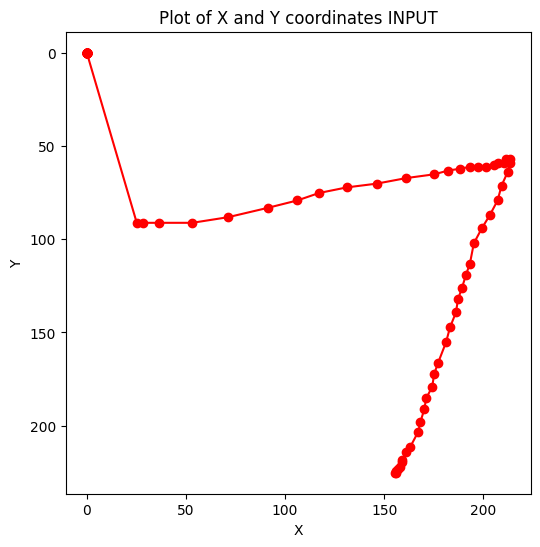

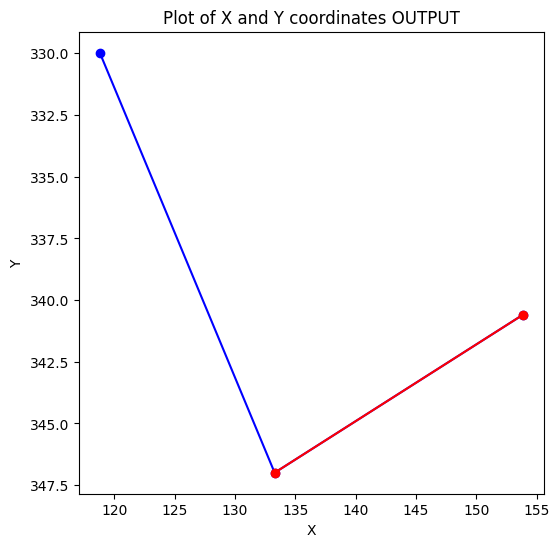

In [408]:
test_user_model_with_output(model, dataloader)

# Test

In [49]:
def test_model_with_output(model, test_loader):
    # Test
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in test_loader:
            save_strokes = batch.float()
            print("save strokes 1st stroke", save_strokes)
            output = model(save_strokes)
            print("output: ", output)
            output = output.view(save_strokes.shape[0], -1, output.size(2))

            img = save_strokes[0, :max_doodle_len-1-1]
            pred = output[0, max_doodle_len-1-1].reshape(1, -1)
            print("shape of pred", pred.shape, "img shape", img.shape)
            viz = torch.floor(torch.cat([img, pred])).numpy()
            viz[viz < 0] = 0
            #draw_strokes_real_time_for_viz(viz)
            # print(viz[-1])
            break


In [ ]:
test_model_with_output(model, test_loader)

# Passing input to the model 


In [156]:
# Pass the input stroke tensor through the model
with torch.no_grad():  # Disable gradient tracking
    model.eval()  # Set model to evaluation mode
    output_stroke_tensor = model(input_stroke_tensor)

# Extract the output stroke tensor
output_stroke_tensor = output_stroke_tensor.squeeze(0)  # Remove batch dimension
print("Output shape:", output_stroke_tensor.shape)

# Convert the output stroke tensor to a numpy array
output_stroke_np = output_stroke_tensor.numpy()

# Print the output stroke
#print("Output stroke:", output_stroke_np)

ValueError: LSTM: Expected input to be 2D or 3D, got 1D instead

In [107]:
def visualize_output_stroke(output_stroke):
    # Calculate the min and max values of x and y coordinates
    min_x = min(output_stroke[:, ::2].flatten())
    max_x = max(output_stroke[:, ::2].flatten())
    min_y = min(output_stroke[:, 1::2].flatten())
    max_y = max(output_stroke[:, 1::2].flatten())
    
    # Calculate the scaling factor
    scale_factor = 200 / max(max_x - min_x, max_y - min_y)
    
    # Create SVG drawing
    dwg = svgwrite.Drawing(size=(250, 250))
    
    # Draw each stroke
    for stroke in output_stroke:
        points = [(int((stroke[i] - min_x) * scale_factor), int((stroke[i + 1] - min_y) * scale_factor)) for i in range(0, len(stroke), 2)]
        polyline = dwg.polyline(points, stroke="black", fill="none", stroke_width=2)
        dwg.add(polyline)
    
    display(SVG(dwg.tostring()))

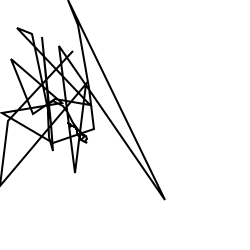

In [108]:
visualize_output_stroke(output_stroke_np)

# Taking user input and loading multiclass models

In [109]:
dataset_paths = {
    "cat": "cat.pth",
    "pig": "pig.pth",
    "cow": "cow.pth",
    "smileface": "smileface.pth",
    "lion": "lion.pth",
    "monkey": "monkey.pth"
}

In [ ]:
user_input = input("Enter the dataset name: ")

if user_input in dataset_paths:
    file_path = dataset_paths[user_input]
    model = torch.load(file_path)
    print(f"Model loaded successfully from {file_path}")
else:
    print("Invalid dataset name. Please choose from: cat, pig, cow, smileface, lion, monkey")